# Composite analysis with Monte Carlo methods: an example with cosmic rays and clouds#

## Benjamin A. Laken & Jasa Čalogović ##

This is an IPython notebook version of [Laken & Calogovic, 2013, doi: 10.1051/swsc/2013051](http://www.swsc-journal.org/articles/swsc/full_html/2013/01/swsc130020/swsc130020.html), published in the **Journal of Space Weather and Space Climate**. Originally, this work was supported by [IDL code](http://www.files.benlaken.com/documents/Laken_Calogovic_2013/), succeeded by this notebook.
ORCID IDs: [B.Laken](http://orcid.org/0000-0003-2021-6258), [J.Čalogović](http://orcid.org/0000-0002-4066-726X).

Code in Python 3, by [B. Laken](http://www.benlaken.com).

### Abstract ###

The composite (superposed epoch) analysis technique has been frequently employed to examine a hypothesized link between solar activity and the Earth’s atmosphere, often through an investigation of Forbush decrease (Fd) events (sudden high-magnitude decreases in the flux cosmic rays impinging on the upper-atmosphere lasting up to several days). This technique is useful for isolating low-amplitude signals within data where background variability would otherwise obscure detection. The application of composite analyses to investigate the possible impacts of Fd events involves a statistical examination of time-dependent atmospheric responses to Fds often from aerosol and/or cloud datasets. Despite the publication of numerous results within this field, clear conclusions have yet to be drawn and much ambiguity and disagreement still remain. In this paper, we argue that the conflicting findings of composite studies within this field relate to methodological differences in the manner in which the composites have been constructed and analyzed. Working from an example, we show how a composite may be objectively constructed to maximize signal detection, robustly identify statistical significance, and quantify the lower-limit uncertainty related to hypothesis testing. Additionally, we also demonstrate how a seemingly significant false positive may be obtained from non-significant data by minor alterations to methodological approaches.

## 1. Introduction ##

The composite analysis technique, also referred to as a superposed epoch analysis, and conditional sampling, is used in numerous fields including geostatistics, fluid dynamics, and plasma physics. It has been frequently employed to examine a hypothesized link between atmospheric properties and sudden decreases in cosmic ray intensity over daily timescales (Forbush decreases). The composite technique is useful for isolating low-amplitude signals within data where background variability would otherwise obscure detection ([Chree 1913](http://rsta.royalsocietypublishing.org/content/212/484-496/75); [1914](http://adsabs.harvard.edu/abs/1914RSPTA.213..245C)). Composite analyses rely on selecting subsets of data, wherein key points in time can be identified based on some criteria, e.g., the occurrence of unusual or extreme events in one or more datasets ([Chree 1913](http://rsta.royalsocietypublishing.org/content/212/484-496/75); [1914](http://adsabs.harvard.edu/abs/1914RSPTA.213..245C); [Forbush et al. 1983](http://link.springer.com/article/10.1007%2FBF00145551)). Through the accumulation and averaging of successive key events, the stochastic background variability may be reduced to a point where low-amplitude signals become identifiable.

To exemplify the composite methodology and how it may be applied to isolate low-amplitude signals, we present the following example. Imagine a regularly sampled time series, $Xi$, where $i = 400$ time units (for ease we shall refer to the these time units as days). As with real-world data, this time series may contain a stochastic (noise) component ($Ni$), and a dynamically determined component ($Di$). Figure 1a shows such a time series, where Di is represented by the addition of two oscillations of differing periods, and Ni is represented by Gaussian (white) noise; the values of both $Ni$ and $Di$ range from 0 to 1. To $Xi$, we have also added a small signal component, $Si$, a regular 5-day deviation of 0.3 units amplitude, repeating at time intervals of 40 days throughout the 400 day time period, so that $Xi = Ni + Di + Si$.


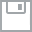
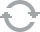
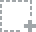
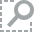
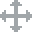
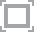
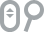
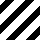
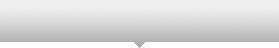
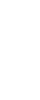
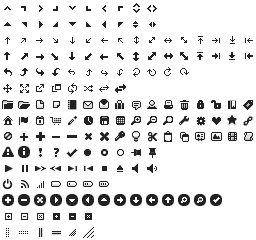
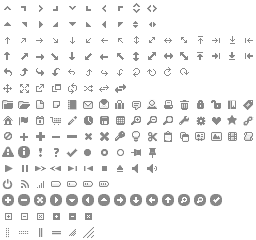
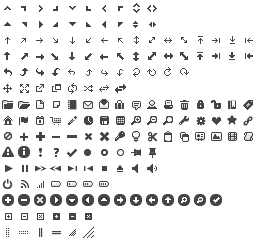
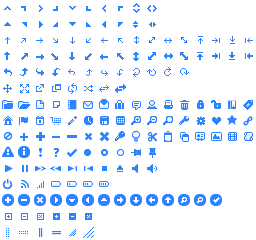
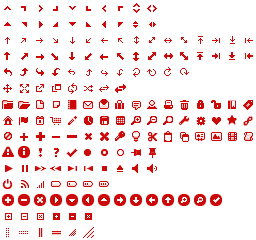
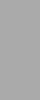
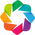
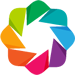

In [1]:
# Load required packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
%matplotlib inline
from bokeh.plotting import figure, show, output_notebook, vplot
from bokeh.io import gridplot
from bokeh.models import HoverTool
from bokeh.models.sources import ColumnDataSource
output_notebook()

In [2]:
# Generate a synthetic time-series with a small and periodic signal to demonstrate the use of composites

tpoints = 400  # Lenght of time-series (unitless)
isubs = np.array(range(tpoints))/50.

# Deterministic component
di =((np.sin(isubs) * 0.5) + (np.sin(np.pi*isubs)*0.3))
di = di + np.abs(np.min(di)) # Make all values positive
di = di / np.max(di)         # Normalize values

# Stochastic component 
ni = np.random.random(tpoints) -0.5  # random values from 0 - 1, shifted by -0.5

# Signal component
si = np.zeros(tpoints)
signal = dict(zip([-2, -1, 0, 1, 2],[-0.333, -0.666, -1., -0.666, -0.333]))
for index in range(20,tpoints,20):
    for n in range(-2,3):
        si[index + n] = signal[n]
si = si * 0.3 # Reduce the 'signal' size

# Combine the componenets into a synthetic time-series
xi = di + ni + si

df_syn = pd.DataFrame(np.c_[xi, ni, di, si], columns=["xi", "ni", "di", "si"])
#df_syn.head()

In [4]:
# Bokeh interactive plot of Figure 1
TOOLS = "pan, wheel_zoom, box_zoom, reset, save, box_select"

p1a = figure(width=400, plot_height=300, title=None, tools=TOOLS)
p1a.line(range(tpoints),df_syn.xi +1.9, legend="Xi",color='black')
p1a.line(range(tpoints),df_syn.di + 0.9, legend="Di",color='red')
p1a.line(range(tpoints),df_syn.si + 0.8, legend="Si",color='blue')
p1a.line(range(tpoints),df_syn.ni, legend="Ni",color='green')
p1a.yaxis.visible = None

p1b = figure(width=400, plot_height=300, title=None, x_range=p1a.x_range, tools=TOOLS)
p1b.line(range(tpoints),df_syn.xi,legend="Xi",color='black')
p1b.line(range(tpoints),pd.rolling_mean(df_syn.xi, window=21, center=True),
        legend="21-day smooth",color='red')
p1b.xaxis.axis_label = "Time (unitless)"
p1b.xaxis.axis_label_text_font_size = '10'
p1b.yaxis.axis_label = "Xi (unitless)"
p1b.yaxis.axis_label_text_font_size = '10'

p1c = figure(width=400, plot_height=300, title=None, tools=TOOLS)
xi_anom = xi - pd.rolling_mean(df_syn.xi, window=21, center=True)
tmp=[]
for index in range(20,tpoints,20):
    tmp.append(xi_anom[index-10:index+11])
tmp = np.array(tmp)
for n in range(len(tmp)):
    p1c.line(range(-10,11),tmp[n,:],color="black",alpha=0.5,legend="Ai, composite matrix (n,t)")
p1c.yaxis.axis_label = "δ Xi (unitless)"
p1c.yaxis.axis_label_text_font_size = '10'

p1d = figure(width=400, plot_height=300, title=None, y_range=p1c.y_range, x_range=p1c.x_range, tools=TOOLS)
stdev = tmp.std(axis=0)
error = stdev/np.sqrt(len(tmp))
mvals = tmp.mean(axis=0)
p1d.circle(range(-10,11), mvals, legend="Ct μ")
p1d.line(range(-10,11), mvals+error,legend="Ct S.E.M")
p1d.line(range(-10,11), mvals-error)

p1d.segment(range(-10, 11), mvals+stdev, range(-10, 11), mvals-stdev, color="black",legend="σ")

p1d.xaxis.axis_label = "Days since signal"
p1d.xaxis.axis_label_text_font_size = '10'
p1d.yaxis.axis_label = "δ Xi (unitless)"
p1d.yaxis.axis_label_text_font_size = '10'

fig1 = gridplot([[p1a,p1c],[p1b,p1d]],toolbar_location=None)
show(fig1)

**Figure 1**: (a) Top left: Fictional time series $Xi$, comprised of deterministic ($Di$), stochastic ($Ni$), and a low-amplitude repeating signal ($Si$) components. $Di$ and $Ni$ range from 0.0 to 1.0, while $Si$ has an amplitude of 0.3. (b) Bottom left: Fi, a 21-point smooth (box-car running mean) of $Xi$. By subtracting $Fi$ from $Xi$ a high-pass filtered dataset $Ai$ is produced. (c) Top right: A composite matrix of events from $Ai$, where rows = $n$, the number of repeating signals in $Si$ (a composite event), and columns = $t$, the number of days since the composite event. (d) Bottom left: $Ct$, the composite means of $Ai$, the standard error of the mean (SEM).

Through the successive averaging of events in the composite methodology we may isolate a low-amplitude signal component from the time series. Before doing this, it is beneficial to attempt to remove variations in $Xi$ that are unconnected to the $Si$ component and may reduce our signal-to-noise ratio (SNR). In reality we may have limited knowledge of the properties of a potential signal component within a dataset. If we suppose the signal we are testing for has an upper-limit length shorter than 7 days, we may set a filter length of three times our maximum expected signal length (e.g., 21 days) to use as a high-pass filter. This may eliminate some noise concerns while leaving our signal unaffected (potential loss of signal from filtering, and noise reduction in composites is discussed in later sections). We then calculate $Fi$, a smooth (running mean) of our dataset with a width set by our expected signal (in our example it is 21-days). The values of $Fi$ (thick line) are shown with $Xi$ in Figure 1b.

By subtracting $Fi$ from $Xi$ we obtain $Ai$, a high-pass filtered dataset, which we shall refer to throughout this work as an anomaly. With prior knowledge of the occurrence times of the signal we may construct a composite matrix, $Mjt$, where $j = 1, … , n$ enumerates the $n$ composite events (matrix rows), and $t$ is the time dimension (matrix columns). We present the composite matrix of $Ai$ in Figure 1c, over a $t = \pm20$ period. In any one of the 10 events in the composite matrix it would be highly difficult to objectively determine the presence of a signal at $t_{0}$. However, by averaging the 10 events of the matrix together to create a composite mean

Equation 1.    $C_{t}=\frac 1 n \displaystyle\sum_{j=0}^{n} M_{jt}$

the noise is reduced by the square root of the number of events

Equation 2.    $\Delta C_{t}=\frac\sigma {\sqrt[]{n}}$

where $\delta C_{t}$ indicates the standard error of the mean (SEM) at $t$ and $\sigma$ is the sample standard deviation of $C_{t}$. As the noise diminishes the signal has an increased chance of being identified. For each time step t, the mean and SEM of the matrix may be calculated using Equations 1 and 2 respectively; these data are presented in Figure 1d, and indeed show the successful isolation of a signal of approximately 0.3 amplitude centered on $t_{0}$. This example and all those presented in this manuscript relate only to one particular statistic, the sample mean, however, any other statistic may also be used. While the composite approach appears straightforward, inconsistencies in the design, creation, and evaluation of composites can strongly affect the conclusions of composites studies and are the focus of this paper.

Numerous composite studies have been published within the field of solar-terrestrial physics, relating to a hypothesized connection between small changes in solar activity and the Earth’s atmosphere (e.g., [Tinsley et al. 1989](http://onlinelibrary.wiley.com/doi/10.1029/JD094iD12p14783/abstract); [Tinsley & Deen 1991](http://onlinelibrary.wiley.com/doi/10.1029/91JD02473/abstract); [Pudovkin & Veretenenko 1995](http://www.sciencedirect.com/science/article/pii/0021916994001092); [Stozhkov et al. 1995](http://link.springer.com/article/10.1007%2FBF02508564); [Egorova et al. 2000](http://www.sciencedirect.com/science/article/pii/S1364682600000808?via%3Dihub); [Fedulina & Laštovička 2001](http://www.sciencedirect.com/science/article/pii/S0273117701003039?via%3Dihub); [Todd & Kniveton 2001](http://onlinelibrary.wiley.com/doi/10.1029/2001JD000405/abstract), [2004](http://www.sciencedirect.com/science/article/pii/S1364682604001166); [Kniveton 2004](http://www.sciencedirect.com/science/article/pii/S1364682604001087); [Harrison & Stephenson 2006](http://rspa.royalsocietypublishing.org/content/462/2068/1221); [Bondur et al. 2008](http://link.springer.com/article/10.1134%2FS1028334X08070283); [Kristjánsson et al. 2008](http://www.atmos-chem-phys.net/8/7373/2008/acp-8-7373-2008.html); [Sloan & Wolfendale 2008](http://iopscience.iop.org/1748-9326/3/2/024001/); [Troshichev et al. 2008](http://www.sciencedirect.com/science/article/pii/S1364682608000886); [Svensmark et al. 2009](http://onlinelibrary.wiley.com/doi/10.1029/2009GL038429/abstract); [Dragić et al. 2011](http://www.astrophys-space-sci-trans.net/7/315/2011/astra-7-315-2011.html); [Harrison et al. 2011](http://rspa.royalsocietypublishing.org/content/467/2134/2777); [Laken & Čalogović 2011](http://onlinelibrary.wiley.com/doi/10.1029/2011GL049764/abstract); [Okike & Collier 2011](http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=6051175); [Laken et al. 2012a](http://onlinelibrary.wiley.com/doi/10.1029/2012JD017683/full); [Mironova et al. 2012](http://www.atmos-chem-phys.net/12/769/2012/acp-12-769-2012.html); [Svensmark et al. 2012](http://www.atmos-chem-phys-discuss.net/12/3595/2012/acpd-12-3595-2012.html); [Artamonova & Veretenenko 2011](http://linkinghub.elsevier.com/retrieve/articleSelectSinglePerm?Redirect=http%3A%2F%2Fwww.sciencedirect.com%2Fscience%2Farticle%2Fpii%2FS1364682610001471%3Fvia%253Dihub&key=1ee359d22d707f4ad53c45d0f658924d9642b104); [Dragić et al. 2013](http://arxiv.org/abs/1304.7879)). However, despite extensive research in this area, clear conclusions regarding the validity of a solar-climate link from composite studies have yet to be drawn. Instead, the numerous composite analyses have produced widely conflicting results: some studies have shown positive statistical associations between the CR flux and cloud properties (e.g., [Tinsley & Deen 1991](http://onlinelibrary.wiley.com/doi/10.1029/91JD02473/abstract); [Pudovkin & Veretenenko 1995](http://www.sciencedirect.com/science/article/pii/0021916994001092); [Todd & Kniveton 2001](http://onlinelibrary.wiley.com/doi/10.1029/2001JD000405/abstract), [2004](http://www.sciencedirect.com/science/article/pii/S1364682604001166); [Kniveton 2004](http://www.sciencedirect.com/science/article/pii/S1364682604001087); [Harrison & Stephenson 2006](http://rspa.royalsocietypublishing.org/content/462/2068/1221); [Svensmark et al. 2009](http://onlinelibrary.wiley.com/doi/10.1029/2009GL038429/abstract), [2012](http://www.atmos-chem-phys-discuss.net/12/3595/2012/acpd-12-3595-2012.html); [Dragić et al. 2011](http://www.astrophys-space-sci-trans.net/7/315/2011/astra-7-315-2011.html),[2013](http://arxiv.org/abs/1304.7879); [Harrison et al. 2011](http://rspa.royalsocietypublishing.org/content/467/2134/2777); [Okike & Collier 2011](http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=6051175)), while others find no clearly significant relationships (e.g., [Lam & Rodger 2002](http://www.sciencedirect.com/science/article/pii/S136468260100092X); [Kristjánsson et al. 2008](http://www.atmos-chem-phys.net/8/7373/2008/acp-8-7373-2008.html); [Sloan & Wolfendale 2008](http://iopscience.iop.org/1748-9326/3/2/024001/); [Laken et al. 2009](http://onlinelibrary.wiley.com/doi/10.1029/2009GL040961/abstract); [Laken & Čalogović 2011](http://onlinelibrary.wiley.com/doi/10.1029/2011GL049764/abstract); [Laken et al. 2011](http://onlinelibrary.wiley.com/doi/10.1029/2010JD014900/abstract); [Laken et al. 2012a](http://onlinelibrary.wiley.com/doi/10.1029/2012JD017683/full); [Čalogović et al. 2010](http://onlinelibrary.wiley.com/doi/10.1029/2009GL041327/full)), or even identify significant correlations of a negative sign (e.g., [Wang et al. 2006](https://inis.iaea.org/search/search.aspx?orig_q=RN:37116597); [Troshichev et al. 2008](http://www.sciencedirect.com/science/article/pii/S1364682608000886)). We suggest that these ambiguities may result from seemingly minor methodological differences between the composites (e.g., relating to the filtering or normalization of data), which are capable of producing widely divergent results. When the dataset is not suited to a particular method of statistical analysis, incorrect conclusions regarding the significance (*i.e.*, the probability $p$-value associated with composite means at given times) of the composites may be reached, which is part of the reason why these aforementioned studies have presented conflicting results.

In this paper, we aim to highlight the methodologies that may produce such conflicts. We provide details on how to properly perform composite analyses of geophysical datasets, and suggest a robust method for estimating the statistical significance of variations over the composite period. Although methods to assess the significance of variations over composites that account for non-random variations have been previously demonstrated (Forbush et al. 1982, 1983; Singh 2006), the incorrect application of statistical tests remains a common feature among composite analyses. Consequently, in this work we also present a further method of assessing statistical significance, which draws from randomized samples of the datasets themselves using a Monte Carlo (MC) methodology and, as a result, makes no assumptions regarding the properties of the data.

## 2. Working from the example of the hypothesized cosmic ray – cloud link ##

Throughout this work we will continue to use the example of testing the hypothesized CR flux/cloud connection to provide examples of various issues that may arise during composite analyses (albeit using real-world data rather than the idealized, fictitious data of Fig. 1). A link between the CR flux and cloud was initially suggested by [Ney (1959)](http://www.nature.com/nature/journal/v183/n4659/abs/183451a0.html), who theorized that the weather might be influenced by variations in the CR flux. [Dickinson (1975)](http://journals.ametsoc.org/doi/abs/10.1175/1520-0477%281975%29056%3C1240%3ASVATLA%3E2.0.CO%3B2) later proposed that such associations may result from an influence of atmospheric ionization produced by the CR flux on the microphysics of aerosols and clouds. Some of the first reports of positive correlations between clouds and cosmic radiation came from the composite studies (e.g., [Tinsley et al. 1989](http://onlinelibrary.wiley.com/doi/10.1029/JD094iD12p14783/abstract); [Pudovkin & Veretenenko 1995](http://www.sciencedirect.com/science/article/pii/0021916994001092); [Pudovkin et al. 1997](http://www.sciencedirect.com/science/article/pii/S0273117797007679)). These and subsequent studies selected time periods based on the occurrence of sudden, high-magnitude reductions in the CR flux impinging on the Earth’s atmosphere, termed Forbush decrease (Fd) events ([Forbush 1938](http://journals.aps.org/pr/abstract/10.1103/PhysRev.54.975)), generated by solar disturbances such as coronal mass ejections ([Lockwood 1971](http://link.springer.com/article/10.1007%2FBF00173346); [Cane 2000](http://link.springer.com/article/10.1023%2FA%3A1026532125747)).

As an example, we will work from a composite of 44 Fd events identified from the Mt. Washington Observatory from 1984 to 1995, located at 44.30°N, 288.70°E, 1,900 m above mean sea level, at a cut-off rigidity of 1.24 GV (the list of Fd events were obtained from http://www.ngdc.noaa.gov/stp/solar/cosmic.html). The Fd events were adjusted so that the maximum CR flux deviation associated with each Fd is aligned with the key composite date (*i.e.*, $t_{0}$ of the composite $x$-axis); without adjustment, the key date would instead be aligned to the date of Fd onset, which may differ from a period of hours-to-days from the maximal reduction in the CR flux (for further details see Laken et al. 2011). Fd events coincident within a ±7 day period of strong (>500 MeV) Solar Proton Events (SPEs) were excluded from the analysis; as such events may produce the opposite ionization effects to those we wish to isolate. Our CR flux data is the same as that of [Laken et al. (2012a)](http://onlinelibrary.wiley.com/doi/10.1029/2012JD017683/full), being a combination of daily averaged Climax Colorado and Moscow neutron monitor data centered on zero (Fig. 2a). In addition, we have also used global daily averaged International Satellite Cloud Climatology Project (ISCCP) D1 total cloud fraction (1000–50 mb) from IR-cloudy pixels (Fig. 2b) which covers the period from 01/07/1983 to 31/12/2009. Throughout this work we will frequently use the cloud data as an anomaly equivalent to $Ai$ described in **Section 1**, with units of %. We again note that the analysis presented here is not meant as a serious test for the hypothesized CR–cloud link, for which other similar studies exist (e.g., [Laken & Čalogović 2011](http://onlinelibrary.wiley.com/doi/10.1029/2011GL049764/abstract)), but rather is presented for demonstration purposes.

In [8]:
data = pd.read_csv("Data/Data.csv")
date_fix = pd.read_csv("Data/dt_index.csv")      # Read original Date data
date_list = []
for entry in zip(date_fix['yyyy'],date_fix['mm'],date_fix['dd']):
    date_list.append(pd.datetime(*entry).date()) # Convert it to a datetime list
df = data.set_index(np.array(date_list))         # set the date list as the df index

The dataframe contains the following from 1983-07-01 to 2009-12-31:

|Variable | Description |
| --- | --- |
|`cld`|  Daily globally avg. ISCCP D1 V13 data (IR-detected cloud cover) originally from NASAs EOSWEB site|
|`cld_360smth` |  the isccp variable with a 360-day box-car filter and edge (+-150day) truncation|
|`cld_360anm`| Daily values subtracted from the 360-day box-car filter|
|`cld_21smth`| a 21-day box-car filter on the cld dataset with edge truncation|
|`cld_21anom`| isccp subtracted from smth21 |
|`CRF`| cosmic ray flux data, derrived using moscow/climate neutron monitors from Laken et al. 2012|
|`CRF_21smth`| CRF data with 21-day box-car filter and edge truncation|
|`CRF_21anom`| CRF anomaly, calculated by subtracting CRF from CRF_21smth|

In [9]:
TOOLS = "pan, wheel_zoom, reset"
p2a = figure(width=800, plot_height=300, tools=TOOLS, x_axis_type = "datetime")
p2a.line(df.index[df['CRF'] > -99.],df['CRF'][df['CRF'] > -99.], 
        legend="Normalized cosmic ray flux (%)",color='black')

p2b = figure(width=800, plot_height=300,x_axis_type = "datetime", 
            title=None, x_range=p2a.x_range, tools=TOOLS)
p2b.line(df.index[df['cld'] > -99.],df['cld'][df['cld'] > -99.],
        legend='Cloud cover (%)',color='black')
p2b.line(df.index[df['cld_21smth'] > -99.],df['cld_21smth'][df['cld_21smth'] > -99.],
        legend="21-day smooth",color='red')

fig2 = gridplot([[p2a],[p2b]],toolbar_location=None)
show(fig2)

**Figure 2** (a) Top panel, daily averaged normalized cosmic ray flux (%) calculated from Climax Colorado and Moscow neutron monitors from [Laken et al. (2012a)](http://onlinelibrary.wiley.com/doi/10.1029/2012JD017683/full). And (b) bottom panel, global, daily averaged, IR-detected cloud fractions (%) from the ISCCP D1 data.

## 3. Constructing a composite ##

### 3.1. Using composites to test a hypothesis ###

After successfully constructing a suitable composite for analysis, anomalies should be objectively examined for evidence of a CR flux-cloud connection via statistical methods. However, it is important to remember that statistics cannot prove any hypothesis; it can only provide a probability that a given hypothesis is or is not correct. Therefore, to test the existence of a hypothesized CR flux-cloud connection, we must construct a null hypothesis that may be tested and possibly rejected. In this instance, the null hypothesis ($H_{0}$) is that fluctuations observed over a composite of Fd events are indistinguishable from natural variability, while $H_{1}$, the alternate hypothesis, is that cloud variations distinguishable from normal (random) variability may be detected in association with the occurrence of Fd events. We must then select a confidence level at which to test our hypothesis: in this instance, we will present statistics for the commonly used 0.05 and 0.01 probability ($p$) value at the two-tailed confidence intervals (hereafter written as $p = 0.05$ and $p = 0.01$).

Detailed procedures relating to the statistical analysis of geophysical data in composite analyses have been published by Forbush et al. (1982, 1983) and Singh (2006), which demonstrate how to assess the significance of non-random (autocorrelated) data. Statistical significance has often been assessed in solar-terrestrial composite analyses by comparing composite means obtained at different times over a composite period, commonly periods prior to and following the occurrence of Fd events are utilized (e.g., [Pudovkin & Veretenenko 1995](http://www.sciencedirect.com/science/article/pii/0021916994001092);  Pudovkin et al. 1997; [Todd & Kniveton 2001](http://onlinelibrary.wiley.com/doi/10.1029/2001JD000405/abstract), 2004; Svensmark et al. 2009; Dragić et al. 2011; Okike & Collier 2011). In relation to this, we importantly note that although composites of geophysical data focusing on Fd events may be considered to be independent in the $n$-dimension (events), they are often highly autocorrelated (dependent) in the t-dimension (time). Thus, an analysis that seeks to compare composite means across $t$ (e.g., in the manner previously described) must account for autocorrelation effects.

In autocorrelated data the value at any given point in time is affected by preceding values. As a result, sequential data points are no longer independent, and so there is less sample variation within the dataset than there would otherwise be if the points were independent. If the variance and the standard deviation (σ) are calculated using the usual formulas, they will be smaller than the true values. Instead, the number of independent data points (effective sample size) must be used to scale the sample variance (Wilks 1997). This adjustment will produce confidence intervals that are larger than when autocorrelations are ignored, making it less likely that a fluctuation in the data will be interpreted as statistically significant at any given $p$-value. In composite analyses, the number of independent data points (*i.e.*, the effective length of the composite sequences) is equivalent to the effective sample size (Forbush et al. 1983): effective sample sizes may be calculated by the methods detailed in Ripley (2009) and Neal (1993). Despite the well-established nature of methods they are not widely applied within the solar-terrestrial community, with numerous studies implementing significance testing that simplistically assumes that the data are independent in the $t$-dimension.

In Section 3.4 we present an additional method of significance testing for composite studies based on Monte Carlo analysis approaches that is highly robust. This method does not rely on comparing composite means at given times over the composite to evaluate significance, but instead evaluates the p-value of each t-point individually, using probability density functions (PDFs) constructed from large numbers of randomly generated samples (with a unique PDF at each $t$-point).

### 3.2. Generating anomalies: the importance of static means in composite analyses ###

To effectively evaluate changes in daily timescale data, variations at timescales beyond the scope of the hypothesis testing should be removed from the dataset. Forbush et al. (1982, 1983) showed that bias can be introduced into traditional statistical tests if fluctuations at longer timescales are not removed. The removal of annual variations alone (which normally dominate geophysical data) will not remove fluctuations that cannot be eliminated by linear de-trending, such as those relating to the effects of planetary-to-synoptic scale systems. Such systems may extend over thousands of kilometers in area, and their influence on atmospheric variability may last from periods of days to several weeks; the random inclusion of their effects in composites may produce fluctuations at timescales shorter than seasonal considerations, yet greater than those concerning our hypothesis testing (so-called intermediate timescales) which may not be removed by linear de-trending. Consequently, when intermediate timescale fluctuations are not accounted for prior to an analysis, it may result in periods of shifted mean values and high autocorrelation being inadvertently included into composites. Suitable filters should be applied to the data to remove longer timescale variability, but to retain variations at timescales that concern the hypothesis testing. In the case of a CR flux-cloud hypothesis, a 21-day running mean (high-pass filter) may be suitable, as the microphysical effects of ionization on aerosol/cloud microphysics are expected to occur at timescales of < 1 week (Arnold 2006).

Although filtering data has the benefit of potentially reducing noise, it should be applied with caution, as it may also introduce artifacts, and reduce or even destroy potential signals altogether. Figure 3a–c shows the influence of a 21-day smooth filter on three idealized symmetrical disturbances of differing length. These disturbances are centered on t 0, each has an amplitude of 100 units in the y-axis dimension and span time periods of (a) 3-days, (b) 7-days, and (c) 11-days. To each time series, a smooth filter of 21-days (i.e., a box-car running mean) has been subtracted from the disturbance (the filters are shown as black lines). The resulting anomalies are shown as the red lines of each figure. As the duration of the idealized disturbance increases, so too does the appearance of overshoot artifacts. From Figure 3a–c, the original (peak-to-trough) signal of 0 to −100 has been shifted by overshoot effects by: (a) +9.6, (b) +19.0, and (c) +27.8. For a and b, the amplitude of the original disturbance is fully preserved, however, as the timescales of the disturbance increase further, the amplitude is reduced. E.g. for the 11-day disturbance the amplitude is diminished by 0.8% compared to the unfiltered signal, while for a 15-day disturbance (not shown) the amplitude decreases by 9%. The amount of signal attenuation will increase as the deviations approach the width of the smooth filter. For deviations at timescales of approximately 1/3rd the width of the smooth filter, the attenuation is negligible. Given this, filters should be applied with care to minimize noise while preserving potential signals. Following the application of the filter in this work we have constrained the reliability of our analysis to time periods of < 7 days.

In [10]:
# Create a dataframe of idealised signals made up of disturbances, ie. a sharp reduction to -100 units,
# spanning a period of 3, 7, 11 and 15 days

def ideal_signal(dist = 7):
    """
    Return an idealised disturbance, peaking at -100 units, in a 1D np.array
    symetrically centered on index 21.
    dist = number of disturbed data points (default is 7)
    """
    signal = np.zeros(41)
    signal_max = -100.
    change_days = (int((dist -1) /2)) # points around key index [20] to inc/dec to signal max
    change_rate = signal_max / (change_days + 1)
    for n, day in enumerate(range(20 - change_days, 21)):
        signal[day] = (n + 1) * change_rate
    for n, day in enumerate(range(21, 21 + change_days)):
        signal[day] = signal[20] + (((n + 1) * change_rate) *-1.)
    return signal

ideal = pd.DataFrame(data=np.c_[ideal_signal(3), ideal_signal(7), ideal_signal(11), ideal_signal(15)],
                     columns=["3-day","7-day","11-day","15-day"], index=range(-20,21))

# Also give a list of values identified of cosmic ray flux change during averaged Forbush decreases
# where the fd is centered on index 40. 
# nb. 81 time points are included below for display due to the long tails of the rolling 21-day mean 
fd_real =np.array([-4.277,-4.452,-4.414,-4.309,-4.182,-4.345,-4.373,-4.596,-4.815,-4.781,-4.825,-4.975,
                   -5.221,-5.019,-5.132,-5.041,-4.875,-4.793,-4.761,-4.596,-4.899,-4.878,-4.877,-4.804,
                   -4.683,-4.875,-5.102,-5.152,-5.093,-4.909,-4.918,-5.054,-5.057,-4.823,-5.013,-5.001,
                   -5.044,-4.798,-5.022,-6.889,-8.972,-8.075,-7.671,-6.920,-6.844,-6.548,-6.510,-6.314,
                   -6.202,-6.048,-5.512,-6.177,-6.518,-6.583,-6.069,-5.755,-5.172,-5.159,-5.059,-5.239,
                   -5.274,-5.003,-4.794,-4.042,-4.794,-4.984,-4.810,-4.488,-4.592,-4.853,-5.089,-5.256,
                   -5.680,-5.545,-5.641,-5.514,-5.627,-5.749,-5.680,-5.579,-5.718])

In [13]:
def get_21smth(values):
    """Return a np array of values for a 21-day running mean"""
    return np.nan_to_num(pd.rolling_mean(values, window=21, center=True))

p3a = figure(width=400, plot_height=300, title=None, tools=TOOLS)
p3b = figure(width=400, plot_height=300, title=None, x_range=p3a.x_range, y_range=p3a.y_range, tools=TOOLS)
p3c = figure(width=400, plot_height=300, title=None, x_range=p3a.x_range, y_range=p3a.y_range, tools=TOOLS)
for p_item, key in zip([p3a, p3b, p3c],["3-day","7-day","11-day"]):
    #p_item = figure(width=400, plot_height=300, title=None, x_range=p1.x_range, y_range=p1.y_range, tools=TOOLS)
    p_item.line(ideal.index, ideal[key],legend=key+' signal',color='blue')
    p_item.line(ideal.index, get_21smth(ideal[key]), legend="21 day avg",color='black')
    p_item.line(ideal.index, ideal[key] - get_21smth(ideal[key]), legend="anomaly",color='red')
    p_item.legend.orientation = "bottom_left"

p3d = figure(width=400, plot_height=300, title=None, x_range=p3a.x_range, tools=TOOLS)
p3d.line(range(-20,21),fd_real[20:61],legend='Fd signal',color='blue')
p3d.line(range(-20,21),get_21smth(fd_real)[20:61], legend="21 day avg", color='black')
p3d.line(range(-20,21), (fd_real[20:61] - get_21smth(fd_real)[20:61])+np.mean(fd_real[20:61]),
        legend="anomaly", color='red')
p3d.legend.orientation = "bottom_left"

fig3 = gridplot([[p3a, p3b],[p3c, p3d]],toolbar_location=None)
show(fig3)

In [40]:
# A keydate list of tuples, with each tuple containing YYYY, MM, DD
fd_events =[(1986,6,2),(1989,3,12),(1989,11,28),(1990,4,7),(1991,3,24)]

# convert these values into a pd.datetime string to operate on
fd_dates = [pd.datetime(year=yyyy,month=mm,day=dd).date() for yyyy, mm, dd in fd_events]

In [72]:
def get_datelist(key_dates, period):
    """ Blah. """
    key_dics = {}
    for tdiff in range(period*-1, period+1): 
        tmp = []
        for date in fd_dates:
            tmp.append(date + dt.timedelta(days=tdiff))
        key_dics[tdiff] = tmp
    return key_dics

In [133]:
d = get_datelist(key_dates=fd_dates, period=40)

In [124]:
#for key in sorted(d.keys()):
#    print(key, np.mean(df.cld_anm21[d[key]]))

In [123]:
#test = {key:np.mean(df.cld_anm21[d[key]]) for key in sorted(d.keys())}

In [136]:
klist = []
val_list = []
for key in sorted(d.keys()):
    klist.append(key)
    val_list.append(np.mean(df.CRF_21anm[d[key]]))

In [36]:
#plt.plot(klist,val_list)

In [141]:
cond1 = df.CRF_21anm != -999

In [34]:
#df.CRF_21anm[cond1]